In [1]:
#Basic Imports 
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import rcParams

#Natural Language Processing 
import nltk
import re 
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

#Sklearn
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

#Classifiers and Models
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

#Model Evaluation and Interpretation
import shap
from sklearn.metrics import confusion_matrix, classification_report, precision_score, accuracy_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score

#Ignore Any Warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
#Let's read in our data 
df = pd.read_csv('/Users/danielleo/Documents/GitHub/covid_19_classifier/covid-19_fake_news_classifier/data/df.csv')
#Reset the index
df = df.set_index("Unnamed: 0")
#And create a binary target 
df['Label'] = df['Label'].map({'Real':0, 'Fake':1,})
#Now let's remove all punctuation from our text data
df["Text"] = df['Text'].str.replace('[^\w\s]','')
#Now let's make sure all the words are lowercase.
df["Text"] = df["Text"].str.lower()
#Now let's create our text column into one where it is just a list of words
df["Text_as_list"] = df["Text"].str.split()
#Now Let's Take a Look-See
df.head()

,Text,Label,Text_as_list
Unnamed: 0,,,
0,american vicepresident mike pence was caught o...,1,"[american, vicepresident, mike, pence, was, ca..."
1,australias covidsafe app tracks users locations,1,"[australias, covidsafe, app, tracks, users, lo..."
2,madagascar has found a coronavirus medicine th...,1,"[madagascar, has, found, a, coronavirus, medic..."
3,a video shows a maasai tribe member in kenya w...,1,"[a, video, shows, a, maasai, tribe, member, in..."
4,a widelycirculated image claims to reveal the ...,1,"[a, widelycirculated, image, claims, to, revea..."


In [4]:
#Let's take a look at our Label values 
df.Label.value_counts()
#Almost 50/50
#Remember 0 is a Real News Story 1 is a Fake News Story

0    1000
1     984
Name: Label, dtype: int64

# WordCloud

In [5]:
all_headlines = ''.join(df['Text'])
stopwords = STOPWORDS
stopwords.add('will')
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="black", max_words=1000).generate(all_headlines)

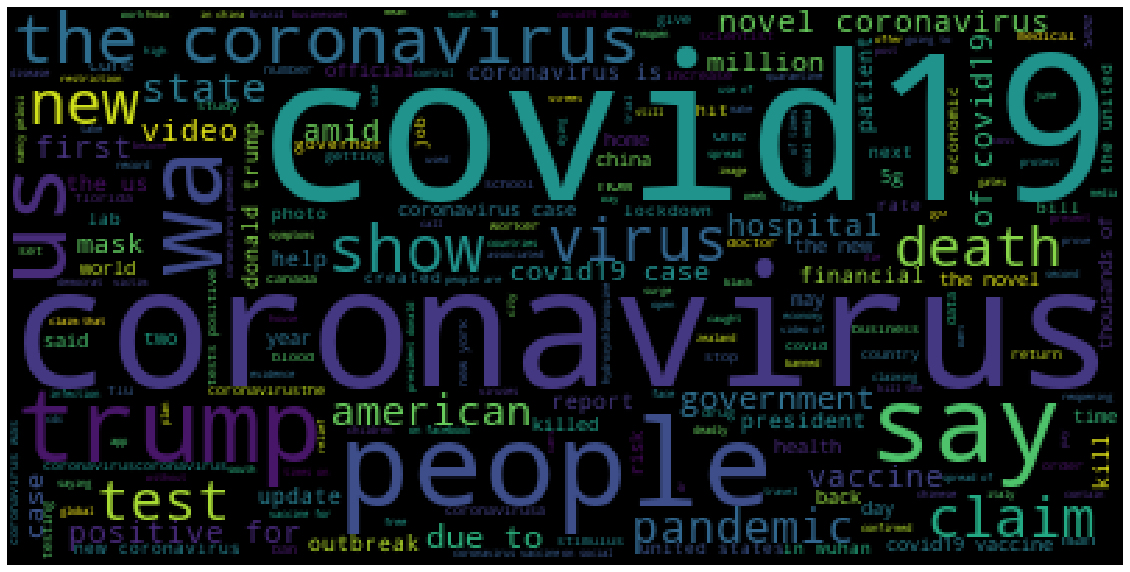

In [6]:
rcParams['figure.figsize'] = 20, 30
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Pre-Processing Continued - Stemming and Lemming

In [7]:
stemmer = PorterStemmer()
lemmer = WordNetLemmatizer()

In [8]:
df['stemmed_text'] = df['Text_as_list'].apply(lambda x: [stemmer.stem(y) for y in x])
df['lemmed_text'] = df["Text_as_list"].apply(lambda x: [lemmer.lemmatize(y) for y in x])
df.head()

,Text,Label,Text_as_list,stemmed_text,lemmed_text
Unnamed: 0,,,,,
0,american vicepresident mike pence was caught o...,1,"[american, vicepresident, mike, pence, was, ca...","[american, vicepresid, mike, penc, wa, caught,...","[american, vicepresident, mike, penny, wa, cau..."
1,australias covidsafe app tracks users locations,1,"[australias, covidsafe, app, tracks, users, lo...","[australia, covidsaf, app, track, user, locat]","[australia, covidsafe, app, track, user, locat..."
2,madagascar has found a coronavirus medicine th...,1,"[madagascar, has, found, a, coronavirus, medic...","[madagascar, ha, found, a, coronaviru, medicin...","[madagascar, ha, found, a, coronavirus, medici..."
3,a video shows a maasai tribe member in kenya w...,1,"[a, video, shows, a, maasai, tribe, member, in...","[a, video, show, a, maasai, tribe, member, in,...","[a, video, show, a, maasai, tribe, member, in,..."
4,a widelycirculated image claims to reveal the ...,1,"[a, widelycirculated, image, claims, to, revea...","[a, widelycircul, imag, claim, to, reveal, the...","[a, widelycirculated, image, claim, to, reveal..."


# Logistic Regression

In [9]:
#Pipeline for Cvec and logistic regresion
pipe_c_lr = Pipeline([('cvec', CountVectorizer()),
                  ('lr', LogisticRegression(solver = 'liblinear'))
                  ])

pipe_para_cvec = {
    'cvec__max_features': [100, 500, 1000],
    'cvec__ngram_range': [(1,2), (1,3), (1,4)],
    'cvec__stop_words' : ['english', None],
    'cvec__min_df': [2, 5, 10],
    'cvec__max_df': [.75, .80, .85, .95]
    }

In [10]:
#Pipeline for Tfidf and logistic regression
pipe_t_lr = Pipeline([('tvec', TfidfVectorizer()),
                  ('lr', LogisticRegression(solver = 'liblinear'))
                  ])

pipe_para_tfidf = {
        'tvec__max_features': [100, 500, 1000],
        'tvec__ngram_range': [(1,2), (1,3), (1,4)],
        'tvec__stop_words': ['english', None],
        'tvec__min_df'    : [2, 5, 10],
        'tvec__max_df'    : [.75, .80, .85, .96]
        
}

In [11]:
pipes = [pipe_c_lr, pipe_t_lr]
pipe_param = [pipe_para_cvec, pipe_para_tfidf]
pipe_names = ['Countvectorizer', 'TfidfVectorizer']

#Let's set up our data for modeling. 
X = df['Text']
y = df['Label']

# Now let's make our training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    stratify=y,
                                                    random_state=42)

for i in range(0, len(pipe_names)):  

    gs = GridSearchCV(pipes[i],
                  param_grid=pipe_param[i], 
                  cv=3)
                
    gs.fit(X_train, y_train)
    gs_estimator = gs.best_estimator_
              
    print(f"Model:{pipe_names[i]}")
    print(f"Best Train Score = {gs_estimator.score(X_train, y_train)}")
    print(f"Best Test Score = {gs_estimator.score(X_test, y_test)}")
    print(f"Best Overall Score = {gs.best_score_}")
    print(f"Best Parameters = {gs.best_params_}")

Model:Countvectorizer
Best Train Score = 0.962822936357908
Best Test Score = 0.8992443324937027
Best Overall Score = 0.8802772526780088
Best Parameters = {'cvec__max_df': 0.75, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 4), 'cvec__stop_words': None}
Model:TfidfVectorizer
Best Train Score = 0.9344675488342785
Best Test Score = 0.8564231738035264
Best Overall Score = 0.8683049779458097
Best Parameters = {'tvec__max_df': 0.75, 'tvec__max_features': 1000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': None}


In [12]:
#Let's take a look at our best estimator
print(gs_estimator)

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.75, max_features=1000,
                                 min_df=2, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [13]:
#Let's generate our best Logistic Regression Predictions
lr_best_preds = gs_estimator.predict(X_test)

#Now let's generate our confusion matrix
lr_cm = confusion_matrix(y_test, lr_best_preds)
lr_cm_df = pd.DataFrame(lr_cm, columns=["Predicted Real", "Predicted Fake"], 
                             index=['Actually Real', 'Actually Fake'])
lr_cm_df

,Predicted Real,Predicted Fake
Actually Real,167,33
Actually Fake,24,173


In [36]:
# Now let's get our confusion matrix metrics 
tn_lr, fp_lr, fn_lr, tp_lr = confusion_matrix(y_test, lr_best_preds).ravel()

# What is the specificity of our test set?
spec_lr = tn_lr / (tn_lr + fp_lr)
print(f'Specificity: {round(spec_lr,4)}')

# What is the sensitivity of our test set?
sens_lr = tp_lr / (tp_lr + fn_lr)
print(f'Sensitivty: {round(sens_lr,4)}')

#Now let's calculate our score 
lr_auc = roc_auc_score(y_test, lr_best_preds)
print('AUC: %.3f' % lr_auc)

#And let's just look at all of our metrics
print(f'The True Negatives are: {tn_lr}')
print(f'The True Positives are: {tp_lr}')
print(f'The False Negatives are: {fn_lr}')
print(f'The False Positives are: {fp_lr}')

#And let's take a look at accuracy
accuracy_lr = (tp_lr + tn_lr) / (tp_lr+tn_lr+fn_lr+fp_lr)
print(f'Accuracy Score: {round(accuracy_lr,4)}')

#And let's take a look at precision 
precision_lr = (tp_lr) / (tp_lr+fp_lr)
print(f'Precision Score: {round(precision_lr,4)}')

Specificity: 0.835
Sensitivty: 0.8782
AUC: 0.857
The True Negatives are: 167
The True Positives are: 173
The False Negatives are: 24
The False Positives are: 33
Accuracy Score: 0.8564
Precision Score: 0.8398


# Decision Tree

In [17]:
#We could create one big pipeline specifying all of the different models we will create. 
#However I think it is best to look at the different methods and break them down along SHAP values to see if 
#There are any insights to take in
pipe_c_dt = Pipeline([('cvec', CountVectorizer()),
                  ('dt', DecisionTreeClassifier())
                  ])

pipe_t_dt = Pipeline([('tvec', TfidfVectorizer()),
                  ('dt', DecisionTreeClassifier())
                  ])

In [18]:
pipes = [pipe_c_dt, pipe_t_dt]
pipe_param = [pipe_para_cvec, pipe_para_tfidf]
pipe_names = ['Countvectorizer', 'TfidfVectorizer']

for i in range(0, len(pipe_names)):  

    gs_dt = GridSearchCV(pipes[i],
                  param_grid=pipe_param[i], 
                  cv=3)
                
    gs_dt.fit(X_train, y_train)
    gs_estimator_dt = gs_dt.best_estimator_
              
    print(f"Model:{pipe_names[i]}")
    print(f"Best Train Score = {gs_estimator_dt.score(X_train, y_train)}")
    print(f"Best Test Score = {gs_estimator_dt.score(X_test, y_test)}")
    print(f"Best Overall Score = {gs_dt.best_score_}")
    print(f"Best Parameters = {gs_dt.best_params_}")

Model:Countvectorizer
Best Train Score = 0.9993698802772527
Best Test Score = 0.8463476070528967
Best Overall Score = 0.794580970384373
Best Parameters = {'cvec__max_df': 0.8, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': None}
Model:TfidfVectorizer
Best Train Score = 0.9993698802772527
Best Test Score = 0.8136020151133502
Best Overall Score = 0.7908002520478891
Best Parameters = {'tvec__max_df': 0.8, 'tvec__max_features': 1000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': None}


In [19]:
#Let's take a look at our best estimator from our Decision Tree Models
print(gs_estimator_dt)

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=1000,
                                 min_df=2, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(...\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('dt',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=None,
        

In [20]:
#Let's look at predictions from our best decision tree classifier
dt_best_preds = gs_estimator_dt.predict(X_test)

#Now let's generate our confusion matrix
dt_cm = confusion_matrix(y_test, dt_best_preds)
dt_cm_df = pd.DataFrame(dt_cm, columns=["Predicted Real", "Predicted Fake"], 
                             index=['Actually Real', 'Actually Fake'])
dt_cm_df

,Predicted Real,Predicted Fake
Actually Real,164,36
Actually Fake,38,159


In [38]:
# Now let's get our confusion matrix metrics 
tn_dt, fp_dt, fn_dt, tp_dt = confusion_matrix(y_test, dt_best_preds).ravel()

# What is the specificity of our test set?
spec_dt = tn_dt / (tn_dt + fp_dt)
print(f'Specificity: {round(spec_dt,4)}')

# What is the sensitivity of our test set?
sens_dt = tp_dt / (tp_dt + fn_dt)
print(f'Sensitivty: {round(sens_dt,4)}')

#Now let's calculate our score 
dt_auc = roc_auc_score(y_test, dt_best_preds)
print('AUC: %.3f' % dt_auc)

#And let's just look at all of our metrics
print(f'The True Negatives are: {tn_dt}')
print(f'The True Positives are: {tp_dt}')
print(f'The False Negatives are: {fn_dt}')
print(f'The False Positives are: {fp_dt}')

#And Lastly let's take a look at accuracy
accuracy_dt = (tp_dt + tn_dt) / (tp_dt+tn_dt+fn_dt+fp_dt)
print(f'Accuracy Score: {round(accuracy_dt,4)}')

#And let's take a look at precision 
precision_dt = (tp_dt) / (tp_dt+fp_dt)
print(f'Precision Score: {round(precision_dt,4)}')

Specificity: 0.82
Sensitivty: 0.8071
AUC: 0.814
The True Negatives are: 164
The True Positives are: 159
The False Negatives are: 38
The False Positives are: 36
Accuracy Score: 0.8136
Precision Score: 0.8154


# Random Forrest

In [22]:
pipe_c_rf = Pipeline([('cvec', CountVectorizer()),
                  ('rf', RandomForestClassifier())
                  ])

pipe_t_rf = Pipeline([('tvec', TfidfVectorizer()),
                  ('rf', RandomForestClassifier())
                  ])

In [23]:
pipes = [pipe_c_rf, pipe_t_rf]
pipe_param = [pipe_para_cvec, pipe_para_tfidf]
pipe_names = ['Countvectorizer', 'TfidfVectorizer']

for i in range(0, len(pipe_names)):  

    gs_rf = GridSearchCV(pipes[i],
                  param_grid=pipe_param[i], 
                  cv=3)
                
    gs_rf.fit(X_train, y_train)
    gs_estimator_rf = gs_rf.best_estimator_
              
    print(f"Model:{pipe_names[i]}")
    print(f"Best Train Score = {gs_estimator_rf.score(X_train, y_train)}")
    print(f"Best Test Score = {gs_estimator_rf.score(X_test, y_test)}")
    print(f"Best Overall Score = {gs_rf.best_score_}")
    print(f"Best Parameters = {gs_rf.best_params_}")

Model:Countvectorizer
Best Train Score = 0.9911783238815375
Best Test Score = 0.8488664987405542
Best Overall Score = 0.8349086326402017
Best Parameters = {'cvec__max_df': 0.8, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 4), 'cvec__stop_words': None}
Model:TfidfVectorizer
Best Train Score = 0.9880277252678009
Best Test Score = 0.8614609571788413
Best Overall Score = 0.8380592312539382
Best Parameters = {'tvec__max_df': 0.96, 'tvec__max_features': 1000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': None}


In [24]:
print(gs_estimator_rf)

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.96, max_features=1000,
                                 min_df=2, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                               

In [25]:
#Let's generate predictions
cvec_preds_rf = gs_estimator_rf.predict(X_test)

#And make our confusion matrix
cvec_cm_rf = confusion_matrix(y_test, cvec_preds_rf)
cvec_cm_rf_df = pd.DataFrame(cvec_cm_rf, columns=["Predicted Real", "Predicted Fake"], 
                             index=['Actually Real', 'Actually Fake'])

cvec_cm_rf_df

,Predicted Real,Predicted Fake
Actually Real,184,16
Actually Fake,39,158


In [39]:
#Now let's get our metrics 
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_test, cvec_preds_rf).ravel()

# What is the specificity of our test set?
spec_rf = tn_rf / (tn_rf + fp_rf)
print(f'Specificity: {round(spec_rf,4)}')

# What is the sensitivity of our test set?
sens_rf = tp_rf / (tp_rf + fn_rf)
print(f'Sensitivty: {round(sens_rf,4)}')

rf_auc = roc_auc_score(y_test, cvec_preds_rf)
print('AUC: %.3f' % rf_auc)

#And let's just look at all of our metrics
print(f'The True Negatives are: {tn_rf}')
print(f'The True Positives are: {tp_rf}')
print(f'The False Negatives are: {fn_rf}')
print(f'The False Positives are: {fp_rf}')

#And Lastly let's take a look at accuracy
accuracy_rf = (tp_rf + tn_rf) / (tp_rf+tn_rf+fn_rf+fp_rf)
print(f'Accuracy Score: {round(accuracy_rf,4)}')

#And let's take a look at precision 
precision_rf = (tp_rf) / (tp_rf+fp_rf)
print(f'Precision Score: {round(precision_rf,4)}')

Specificity: 0.92
Sensitivty: 0.802
AUC: 0.861
The True Negatives are: 184
The True Positives are: 158
The False Negatives are: 39
The False Positives are: 16
Accuracy Score: 0.8615
Precision Score: 0.908


# XGBOOST

In [27]:
pipe_c_xgb = Pipeline([('cvec', CountVectorizer()),
                  ('xgb', XGBClassifier())
                  ])

pipe_t_xgb = Pipeline([('tvec', TfidfVectorizer()),
                  ('xgb', XGBClassifier())
                  ])

In [28]:
pipes = [pipe_c_xgb, pipe_t_xgb]
pipe_param = [pipe_para_cvec, pipe_para_tfidf]
pipe_names = ['Countvectorizer', 'TfidfVectorizer']

for i in range(0, len(pipe_names)):  

    gs_xgb = GridSearchCV(pipes[i],
                  param_grid=pipe_param[i], 
                  cv=3)
                
    gs_xgb.fit(X_train, y_train)
    gs_estimator_xgb = gs_xgb.best_estimator_
              
    print(f"Model:{pipe_names[i]}")
    print(f"Best Train Score = {gs_estimator_xgb.score(X_train, y_train)}")
    print(f"Best Test Score = {gs_estimator_xgb.score(X_test, y_test)}")
    print(f"Best Overall Score = {gs_xgb.best_score_}")
    print(f"Best Parameters = {gs_xgb.best_params_}")

Model:Countvectorizer
Best Train Score = 0.8664146187775678
Best Test Score = 0.8639798488664987
Best Overall Score = 0.8292375551354757
Best Parameters = {'cvec__max_df': 0.75, 'cvec__max_features': 1000, 'cvec__min_df': 5, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None}
Model:TfidfVectorizer
Best Train Score = 0.8720856962822936
Best Test Score = 0.8513853904282116
Best Overall Score = 0.8197857592942659
Best Parameters = {'tvec__max_df': 0.75, 'tvec__max_features': 500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}


In [29]:
print(gs_estimator_xgb)

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.75, max_features=500,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                        

In [30]:
#Let's generate predictions
cvec_preds_xgb = gs_estimator_xgb.predict(X_test)

#And make our confusion matrix
cvec_cm_xgb = confusion_matrix(y_test, cvec_preds_xgb)
cvec_cm_xgb_df = pd.DataFrame(cvec_cm_xgb, columns=["Predicted Real", "Predicted Fake"], 
                             index=['Actually Real', 'Actually Fake'])

cvec_cm_xgb_df

,Predicted Real,Predicted Fake
Actually Real,185,15
Actually Fake,44,153


In [40]:
#Now let's get our metrics 
tn_xgb, fp_xgb, fn_xgb, tp_xgb = confusion_matrix(y_test, cvec_preds_xgb).ravel()

# What is the specificity of our test set?
spec_xgb = tn_xgb / (tn_xgb + fp_xgb)
print(f'Specificity: {round(spec_xgb,4)}')

# What is the sensitivity of our test set?
sens_xgb = tp_xgb / (tp_xgb + fn_xgb)
print(f'Sensitivty: {round(sens_xgb,4)}')

xgb_auc = roc_auc_score(y_test, cvec_preds_xgb)
print('AUC: %.3f' % xgb_auc)

#And let's just look at all of our metrics
print(f'The True Negatives are: {tn_xgb}')
print(f'The True Positives are: {tp_xgb}')
print(f'The False Negatives are: {fn_xgb}')
print(f'The False Positives are: {fp_xgb}')

#And Lastly let's take a look at accuracy
accuracy_xgb = (tp_xgb + tn_xgb) / (tp_xgb+tn_xgb+fn_xgb+fp_xgb)
print(f'Accuracy Score: {round(accuracy_xgb,4)}')

#And let's take a look at precision 
precision_xgb = (tp_xgb) / (tp_xgb+fp_xgb)
print(f'Precision Score: {round(precision_xgb,4)}')

Specificity: 0.925
Sensitivty: 0.7766
AUC: 0.851
The True Negatives are: 185
The True Positives are: 153
The False Negatives are: 44
The False Positives are: 15
Accuracy Score: 0.8514
Precision Score: 0.9107


# SHAP Values

In [32]:
xgb_pipe = Pipeline([('tvec', TfidfVectorizer(max_df=.75, max_features=500, min_df=2, ngram_range=(1,2), stop_words=None)),
                  ('xgb', XGBClassifier())
                  ])

#For now you can (as you mentioned) just use the class_names=model.classes_ option of the summary plot.

In [33]:
xgb_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.75, max_features=500,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                        

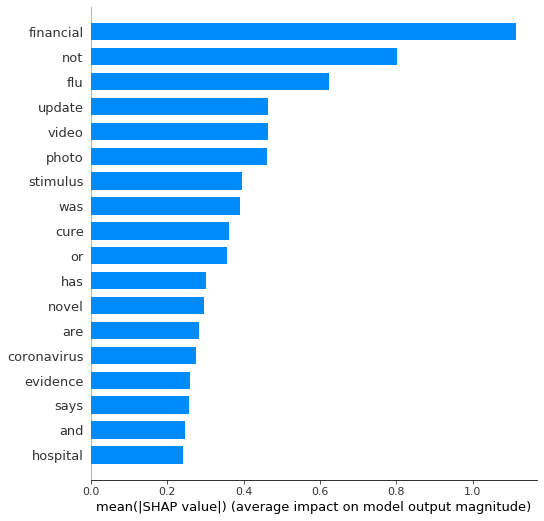

In [35]:
X_test_tfidf = pd.DataFrame(xgb_pipe['tvec'].transform(X_test).toarray(), 
                            columns=xgb_pipe['tvec'].get_feature_names())

explainer = shap.TreeExplainer(xgb_pipe['xgb'])

shap_values = explainer.shap_values(X_test_tfidf)

shap.summary_plot(shap_values, X_test_tfidf, plot_type='bar', max_display=18, class_names=xgb_pipe.classes_)